# Emotion Classification in texts using LSTM and Word2Vec

### Architecture: 
(X) Text -> Embedding (W2V pretrained on wikipedia articles) -> Deep Network (CNN 1D) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

#### Embedding Layer
* Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#### Deep Network
* Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position. 

#### Fully Connected Layer
* The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.

#### Output Layer
* Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pre-trained W2V
4. Create Neural Network Pipeline
5. Train The Model
6. Evaluate results


## 1. Import Data


In [14]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

Defining vector space dimension and fixed input size

In [15]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [26]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = pd.concat([data_train, data_test], ignore_index=True)

In [36]:
print(data.Emotion.value_counts())
data.head(20)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...
6,joy,Finding out I am chosen to collect norms for C...
7,anger,A spokesperson said : ` Glen is furious that t...
8,neutral,Yes .
9,sadness,"When I see people with burns I feel sad, actua..."


### Exploratory data analysis

In [5]:
print(f"Length of dataset is {len(data)}")

Length of dataset is 11327


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11327 entries, 0 to 11326
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  11327 non-null  object
 1   Text     11327 non-null  object
dtypes: object(2)
memory usage: 177.1+ KB


In [7]:
data.isna().sum()

Emotion    0
Text       0
dtype: int64

[Text(0, 0, 'joy'),
 Text(1, 0, 'sadness'),
 Text(2, 0, 'anger'),
 Text(3, 0, 'neutral'),
 Text(4, 0, 'fear')]

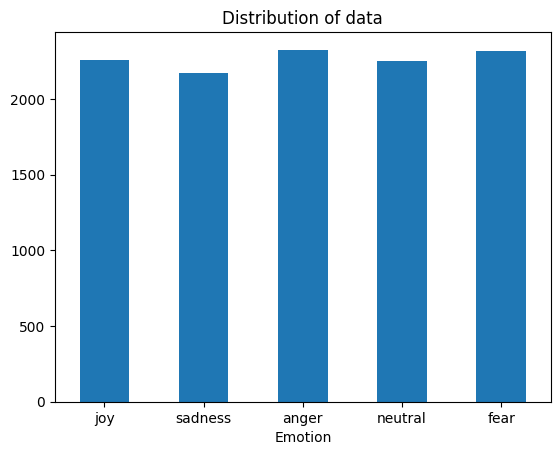

In [8]:
# Plotting the distribution for dataset.
ax = data.groupby('Emotion').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['joy','sadness','anger','neutral', 'fear'], rotation=0)

## 2. Prepare input data
To input the data to our NN Model we'll need some preprocessing:
1. Tokenize our texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

Basic preprocessing and tokenization using nltk to double check that sentences are properly split into words.
We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning

In [27]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [28]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [29]:
print(texts_train)

['There are tons of other paintings that I think are better .', 'Yet the dog had grown old and less capable , and one day the gillie had come and explained with great sorrow that the dog had suffered a stroke , and must be put down .', 'When I get into the tube or the train without paying for the ticket .', 'This last may be a source of considerable disquiet and one might not at first see how such obviously ` immoral `` content could be defended as part of a system of morality .', 'She disliked the intimacy he showed towards some of them , was resentful of the memories they shared of which she was not a part , and felt excluded .', "When my family heard that my Mother 's cousin who lives in England wrote us to tell that he had cancer of the lymph glands .", "Finding out I am chosen to collect norms for Chinese aphasia ( I will contribute to China 's catching up with the West in neuropsychology ) .", 'A spokesperson said : ` Glen is furious that the new ` Anarchy `` promo features foota

**Tokenization + fitting using keras**

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12087


In [39]:
import json

# Save tokenizer's word index and configuration to a JSON file
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json.dump(tokenizer_json, json_file)


**Padding** -> each input has the same length

We defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght (longest input in our dataset is ~250 words)

In [13]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]])

**Categorize** labels: 

In [31]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [32]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

* Importing pretrained word2vec from file and creating embedding matrix
* We will later map each word in our corpus to existing word vector

In [16]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [17]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [18]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

Some of the words from our corpus were not included in the pre-trained word vectors. If we inspect those words we'll see that it's mostly spelling errors. It's also good to double check the noise in our data f.e different languages or tokenizer errors.

In [19]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


## 3. Create CNN Pipeline

### Embedding Layer

We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights 

* **vocabulary size:** the maximum number of terms that are used to represent a text: e.g. if we set the size of the “vocabulary” to 1000 only the first thousand terms most frequent in the corpus will be considered (and the other terms will be ignored)
* **the maximum length:** of the texts (which must all be the same length)
* **size of embeddings:** basically, the more dimensions we have the more precise the semantics will be, but beyond a certain threshold we will lose the ability of the embedding to define a coherent and general enough semantic area
* **trainable:** True if you want to fine-tune them while training


In [20]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- we will use 1D convolutional neural network to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words)
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

In [21]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 conv1d (Conv1D)             (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3924133 (14.97 MB)
Trainable params: 297733 (1.14 MB)
Non-trainable params: 3626400 (13.83 MB)
_____________

## 3. Train the Model

In [23]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
31/31 [==============================] - 73s 2s/step - loss: 1.3270 - accuracy: 0.4802 - val_loss: 1.0705 - val_accuracy: 0.6166
Epoch 2/6
31/31 [==============================] - 71s 2s/step - loss: 0.8166 - accuracy: 0.7157 - val_loss: 0.8111 - val_accuracy: 0.6941
Epoch 3/6
31/31 [==============================] - 72s 2s/step - loss: 0.6043 - accuracy: 0.7927 - val_loss: 0.7326 - val_accuracy: 0.7356
Epoch 4/6
31/31 [==============================] - 71s 2s/step - loss: 0.4749 - accuracy: 0.8495 - val_loss: 0.7065 - val_accuracy: 0.7486
Epoch 5/6
31/31 [==============================] - 71s 2s/step - loss: 0.3718 - accuracy: 0.8915 - val_loss: 0.7188 - val_accuracy: 0.7542
Epoch 6/6
31/31 [==============================] - 71s 2s/step - loss: 0.2886 - accuracy: 0.9212 - val_loss: 0.7074 - val_accuracy: 0.7545


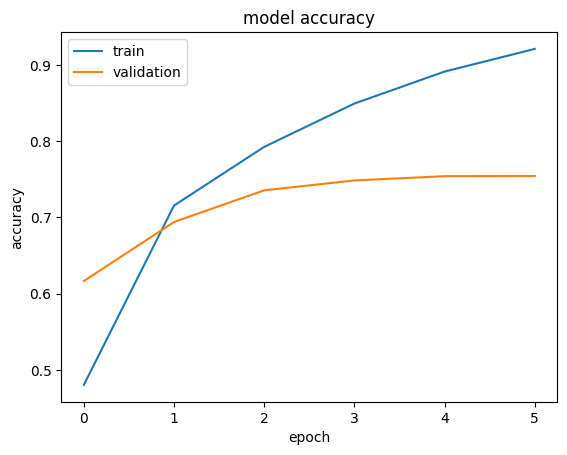

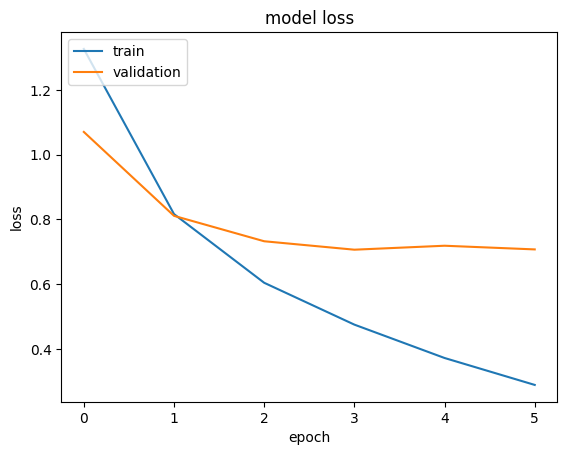

In [24]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [25]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

107/107 [==============================] - 10s 93ms/step


In [26]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 75.45%

F1 Score: 75.45


#### Plotting confusion Matrix:

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 75.45


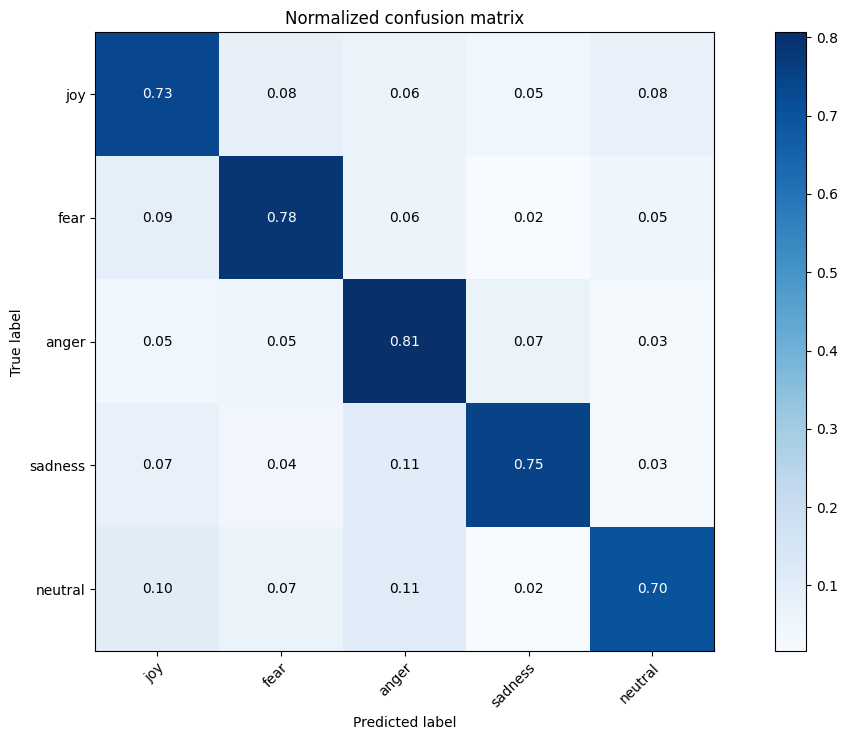

In [30]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#### Let's try other inputs:

In [31]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [40]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)
print(pred)
print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 83ms/step
[[0.03835169 0.2937929  0.5222017  0.08651958 0.05913415]]
Message: ['delivery was hour late and my pizza was cold!']
predicted: anger (0.40 seconds)


# Saving the Model

In [34]:
# creates a HDF5 file 'my_model.h5'
model.save('models/cnn_w2v.keras')

In [35]:
from keras.models import load_model
predictor = load_model('models/cnn_w2v.keras')

### DEBIASED  WORD EMBEDDING

In [1]:
import json
from gensim.models import Word2Vec
from debiaswe import we
from debiaswe.debias import debias,soft_debias
from debiaswe.we import WordEmbedding
from debiaswe.data import load_professions

In [2]:
E = WordEmbedding('embeddings/wiki-news-300d-1M.vec')

*** Reading data from embeddings/wiki-news-300d-1M.vec
(999994, 300)
999994 words of dimension 300 : ,, the, ., and, ..., sacoglossan, Iseya, Bayyah, Vilaya
999994 words of dimension 300 : ,, the, ., and, ..., sacoglossan, Iseya, Bayyah, Vilaya


In [3]:
# Lets load some gender related word lists to help us with debiasing
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)

with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself']]
gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [4]:
debias(E, gender_specific_words, defs, equalize_pairs)

999994 words of dimension 300 : ,, the, ., and, ..., sacoglossan, Iseya, Bayyah, Vilaya
{('GRANDPA', 'GRANDMA'), ('Males', 'Females'), ('wives', 'husbands'), ('Father', 'Mother'), ('monastery', 'convent'), ('MONASTERY', 'CONVENT'), ('BROTHERS', 'SISTERS'), ('EX_GIRLFRIEND', 'EX_BOYFRIEND'), ('Colt', 'Filly'), ('fella', 'granny'), ('his', 'her'), ('COUNCILMAN', 'COUNCILWOMAN'), ('HIS', 'HER'), ('Prostate_Cancer', 'Ovarian_Cancer'), ('gentleman', 'lady'), ('UNCLE', 'AUNT'), ('chairman', 'chairwoman'), ('Fraternity', 'Sorority'), ('DUDES', 'GALS'), ('MALE', 'FEMALE'), ('prince', 'princess'), ('BOYS', 'GIRLS'), ('TESTOSTERONE', 'ESTROGEN'), ('Schoolboy', 'Schoolgirl'), ('Grandpa', 'Grandma'), ('Grandsons', 'Granddaughters'), ('GRANDFATHER', 'GRANDMOTHER'), ('SONS', 'DAUGHTERS'), ('Dads', 'Moms'), ('FRATERNITY', 'SORORITY'), ('KING', 'QUEEN'), ('brother', 'sister'), ('He', 'She'), ('boy', 'girl'), ('Councilman', 'Councilwoman'), ('spokesman', 'spokeswoman'), ('Man', 'Woman'), ('PRINCE', 'PR

In [10]:
from keras.preprocessing.text import tokenizer_from_json
import json

# Load tokenizer from JSON file
with open('embeddings/tokenizer.json') as json_file:
    tokenizer_json = json.load(json_file)
    tokenizer = tokenizer_from_json(tokenizer_json)
index_of_words = tokenizer.word_index

In [30]:
sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [11]:
def create_embedding_matrix_debiased(E, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 for reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize matrix with zeros

    # Create a mapping of words to their vectors
    embedding_dict = {word: E.vecs[idx] for idx, word in enumerate(E.words)}

    for word, idx in word_index.items():
        if word in embedding_dict:  # If the word exists in the debiased embedding
            embedding_matrix[idx] = embedding_dict[word][:embedding_dim]
    
    return embedding_matrix


In [17]:
embedd_matrix_debiased = create_embedding_matrix_debiased(E, index_of_words, embed_num_dims)
embedd_matrix_debiased.shape

(12088, 300)

In [19]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix_debiased[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


In [21]:
vocab_size = len(index_of_words) + 1

In [22]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix_debiased],
                         trainable=False)

In [24]:
# Convolution
kernel_size = 3
filters = 256

debiased_model = Sequential()
debiased_model.add(embedd_layer)
debiased_model.add(Conv1D(filters, kernel_size, activation='relu'))
debiased_model.add(GlobalMaxPooling1D())
debiased_model.add(Dense(256, activation='relu'))
debiased_model.add(Dense(num_classes, activation='softmax'))

In [25]:
debiased_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
debiased_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626400   
                                                                 
 conv1d_1 (Conv1D)           (None, 498, 256)          230656    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3924133 (14.97 MB)
Trainable params: 297733 (1.14 MB)
Non-trainable params: 3626400 (13.83 MB)
___________

In [33]:
batch_size = 256
epochs = 6

hist = debiased_model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
31/31 [==============================] - 73s 2s/step - loss: 1.4354 - accuracy: 0.3972 - val_loss: 1.2439 - val_accuracy: 0.5090
Epoch 2/6
31/31 [==============================] - 71s 2s/step - loss: 1.0147 - accuracy: 0.6456 - val_loss: 0.8977 - val_accuracy: 0.6770
Epoch 3/6
31/31 [==============================] - 226s 7s/step - loss: 0.7081 - accuracy: 0.7525 - val_loss: 0.7634 - val_accuracy: 0.7259
Epoch 4/6
31/31 [==============================] - 71s 2s/step - loss: 0.5725 - accuracy: 0.8089 - val_loss: 0.7207 - val_accuracy: 0.7389
Epoch 5/6
31/31 [==============================] - 69s 2s/step - loss: 0.4787 - accuracy: 0.8445 - val_loss: 0.7019 - val_accuracy: 0.7539
Epoch 6/6
31/31 [==============================] - 71s 2s/step - loss: 0.3937 - accuracy: 0.8816 - val_loss: 0.6993 - val_accuracy: 0.7501


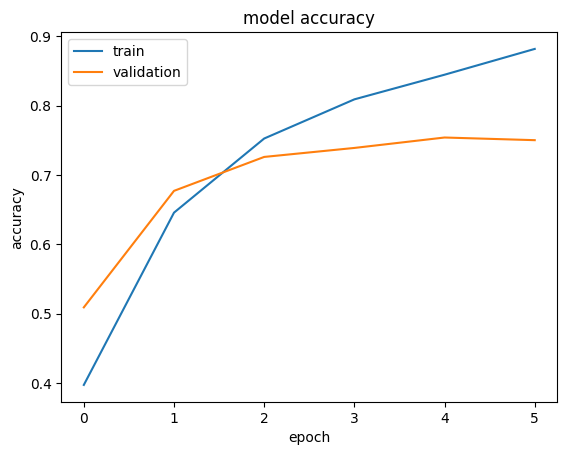

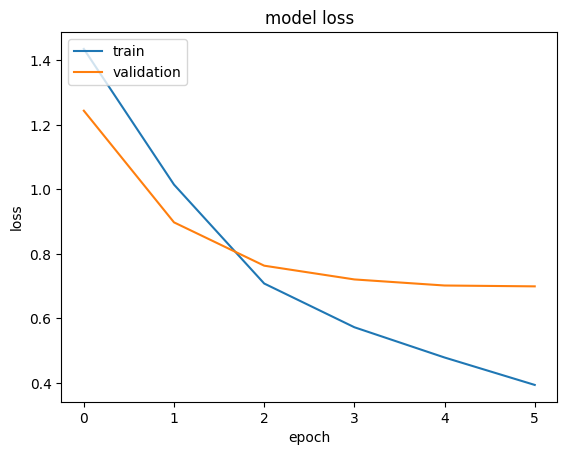

In [34]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
predictions = debiased_model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

107/107 [==============================] - 11s 99ms/step


In [37]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 75.01%

F1 Score: 75.01


In [40]:
debiased_model.save('models/cnn_w2v_debiased.keras')


F1 Score: 75.01


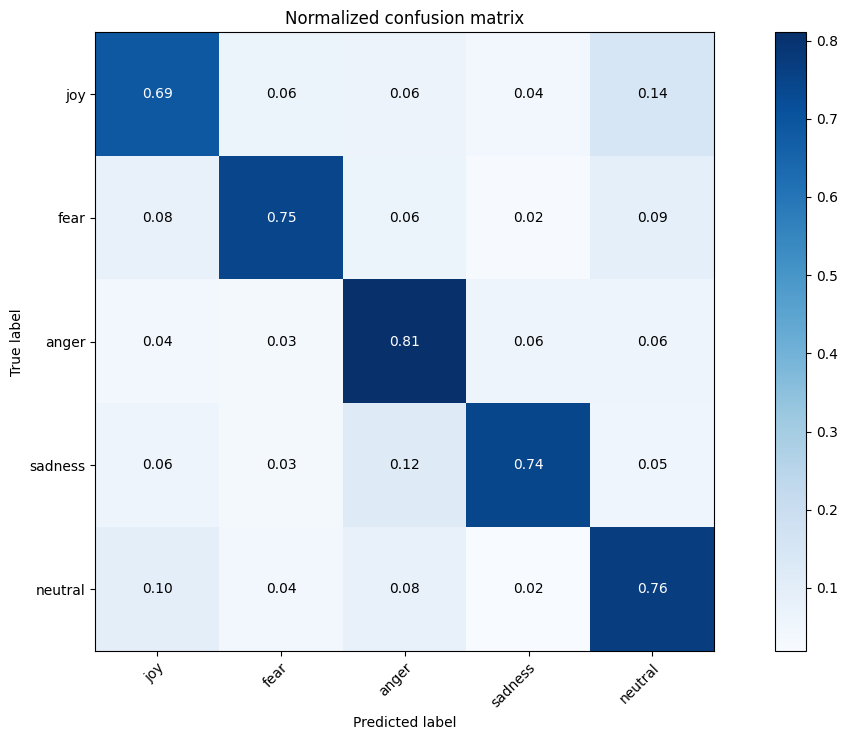

In [39]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()